In [34]:
import xarray as xr
import pandas as pd
import os
import numpy as np

# Folder containing NetCDF files
folder_path = "/home/pcuser/titanlib/notebooks/nebelhorn"

# Define the target timestamp
# Best Time: 2022-01-22 12:00:00 with 94 stations having data

target_time = pd.to_datetime("2022-01-22-T12:00:00")


# List to store extracted data
data_list = []

# Loop through all NetCDF files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".nc"):
        file_path = os.path.join(folder_path, file)
        
        # Open the NetCDF file
        ds = xr.open_dataset(file_path)
        
        # Extract station name (assuming it's in the filename)
        station_name = file.split(".nc")[0]  # Modify if needed
        
        # Convert time if it is stored as "hours since X"
        if np.issubdtype(ds.time.dtype, np.integer) or np.issubdtype(ds.time.dtype, np.floating):
            try:
                ds["time"] = xr.decode_cf(ds).time  # Automatically converts "hours since X" format
            except Exception:
                print(f"Warning: Could not auto-decode time for {file}")
        
        # Ensure time is in datetime64 format
        ds["time"] = pd.to_datetime(ds["time"].values)
        
        # Select the nearest time
        ds = ds.sel(time=target_time, method="nearest")

        # Extract variables (modify as needed)
        temp = ds.get("temp", None)
        rel_hum = ds.get("rel_hum", None)
        wind_speed = ds.get("wind_speed", None)
        wind_dir = ds.get("wind_dir", None)
        lat = ds.get("lat", None)
        lon = ds.get("lon", None)
        alt = ds.get("alt", None)

      #  print(f"Variables in {file}: {list(ds.variables.keys())}")
      #  print("Temp is: ", temp.values if temp is not None else "None")

        # Store extracted data
        data_list.append({
            "Station": station_name,
            "Time": str(ds.time.values),
            "Temperature": float(temp.values) if temp is not None else None,
            "RH": float(rel_hum.values) if pressure is not None else None,
            "Wind Speed": float(wind_speed.values) if wind_speed is not None else None,
            "Wind Dir": float(wind_dir.values) if wind_speed is not None else None,
            "Latitude": float(lat.values) if lat is not None else None,
            "Longitude": float(lon.values) if lon is not None else None,
            "Altitude": float(alt.values) if alt is not None else None,
            

        })
        
        ds.close()

# Convert to Pandas DataFrame for easy comparison
df = pd.DataFrame(data_list)

# Display the DataFrame
print(df)

# Optionally, save to CSV
df.to_csv("weather_comparison.csv", index=False)



              Station                           Time  Temperature    RH  \
0     nebelhorn-pit_3  2022-01-22T12:00:00.000000000          NaN  None   
1   nebelhorn-pit_116  2022-01-22T12:00:00.000000000   271.133333  None   
2   nebelhorn-pit_305  2022-01-22T12:00:00.000000000          NaN  None   
3   nebelhorn-pit_209  2022-01-22T12:00:00.000000000          NaN  None   
4   nebelhorn-pit_119  2022-01-22T12:00:00.000000000   271.225000  None   
..                ...                            ...          ...   ...   
89  nebelhorn-pit_611  2022-01-22T12:00:00.000000000          NaN  None   
90  nebelhorn-pit_213  2022-01-22T12:00:00.000000000   270.291667  None   
91           dwd_3730  2022-01-22T12:00:00.000000000   272.950000  None   
92  nebelhorn-pit_101  2022-01-22T12:00:00.000000000   270.625000  None   
93  nebelhorn-pit_306  2022-01-22T12:00:00.000000000          NaN  None   

    Wind Speed  Wind Dir   Latitude  Longitude     Altitude  
0          NaN       NaN  47.409702  

CSV saved to output_file_test_14032025.csv


In [35]:
import titanlib

# Extract the relevant columns
latitude = df['Latitude'].values
longitude = df['Longitude'].values
altitude = df['Altitude'].values
temperature = df['Temperature'].values  # Observations (e.g., temperature)

# Create TitanLib Points object
points = titanlib.Points(latitude, longitude, altitude, temperature)
flags = titanlib.metadata_check(
    points, True, True, True, True
)

print(flags)

[1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0
 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1]


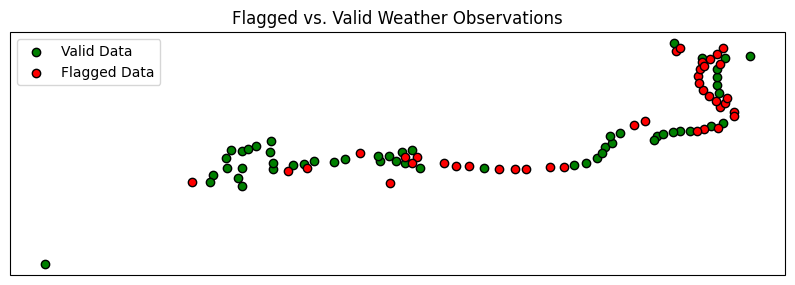

In [36]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Extract flagged and unflagged indices
flagged_indices = np.where(flags != 0)[0]  # Flags that are not 0 (invalid)
unflagged_indices = np.where(flags == 0)[0]  # Valid data points

# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Plot valid observations (green)
ax.scatter(
    longitude[unflagged_indices], latitude[unflagged_indices],
    c="green", label="Valid Data", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot flagged observations (red)
ax.scatter(
    longitude[flagged_indices], latitude[flagged_indices],
    c="red", label="Flagged Data", edgecolors="black", transform=ccrs.PlateCarree()
)

# Add title & legend
ax.set_title("Flagged vs. Valid Weather Observations")
ax.legend()

# Show the map
plt.show()


In [50]:
##Buddy check:


radius = np.full(points.size(), 5000)
num_min = np.full(points.size(), 5)
threshold = 2
max_elev_diff = 200
elev_gradient = -0.0065
min_std = 1
num_iterations = 5

# Extract the relevant columns
latitude = df['Latitude'].values
longitude = df['Longitude'].values
altitude = df['Altitude'].values
temperature = df['Temperature'].values  # Observations (e.g., temperature)

# Create TitanLib Points object
points = titanlib.Points(latitude, longitude, altitude, temperature)


flags_buddy_check = titanlib.buddy_check(
    points,
    temperature,
    radius,
    num_min,
    threshold,
    max_elev_diff,
    elev_gradient,
    min_std,
    num_iterations,
)

print(flags_buddy_check)


[1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0
 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1]


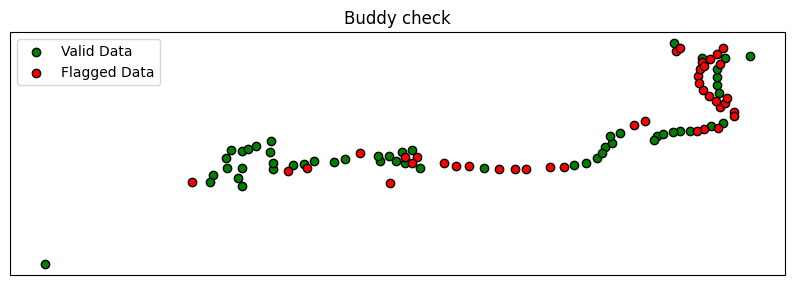

In [51]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Extract flagged and unflagged indices
flagged_indices = np.where(flags_buddy_check != 0)[0]  # Flags that are not 0 (invalid)
unflagged_indices = np.where(flags_buddy_check == 0)[0]  # Valid data points

# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Plot valid observations (green)
ax.scatter(
    longitude[unflagged_indices], latitude[unflagged_indices],
    c="green", label="Valid Data", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot flagged observations (red)
ax.scatter(
    longitude[flagged_indices], latitude[flagged_indices],
    c="red", label="Flagged Data", edgecolors="black", transform=ccrs.PlateCarree()
)

# Add title & legend
ax.set_title("Buddy check")
ax.legend()

# Show the map
plt.show()


[1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 0
 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0
 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1]


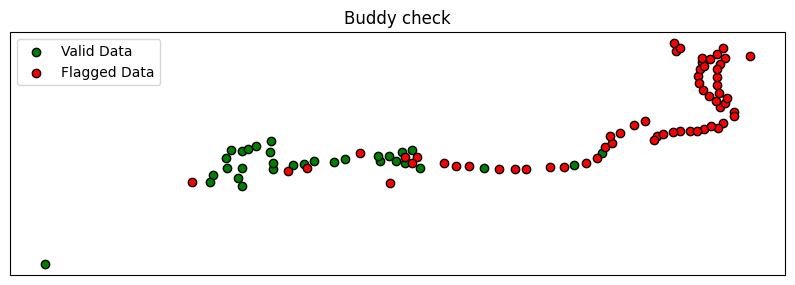

In [64]:
min = [270]*len(temperature)
max = [290]*len(temperature)
flags_range_check = titanlib.range_check(
    temperature, min, max)

print(flags_range_check)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Extract flagged and unflagged indices
flagged_indices = np.where(flags_range_check != 0)[0]  # Flags that are not 0 (invalid)
unflagged_indices = np.where(flags_range_check == 0)[0]  # Valid data points

# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Plot valid observations (green)
ax.scatter(
    longitude[unflagged_indices], latitude[unflagged_indices],
    c="green", label="Valid Data", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot flagged observations (red)
ax.scatter(
    longitude[flagged_indices], latitude[flagged_indices],
    c="red", label="Flagged Data", edgecolors="black", transform=ccrs.PlateCarree()
)

# Add title & legend
ax.set_title("Range check")
ax.legend()

# Show the map
plt.show()

In [62]:
print(len(temperature))
print(np.arange(0,94,1))

hi=[0]*len(temperature)
print(hi)

94
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
import xarray as xr

# Load the NetCDF file
file_path = "nebelhorn/nebelhorn-pit_405.nc"  # Update with the correct path
ds = xr.open_dataset(file_path)

# Convert time to datetime format
ds["time"] = xr.decode_cf(ds)["time"]

# Target time
target_time = "2022-01-13T17:00:00"

# Select the nearest available time

ds_selected = ds.sel(time=target_time, method="nearest")

# Extract temperature if available
temperature = ds_selected.get("temperature", None)

# Get actual selected time and temperature value
selected_time = ds_selected.time.values
temperature_value = float(temperature.values) if temperature is not None else None

print(f"Selected Time: {selected_time}")
print(f"Temperature: {temperature_value}")


Selected Time: 2022-01-13T17:00:00.000000000
Temperature: None


In [15]:
print(flags == 1)  # Check the boolean array generated by flags == 1
print(df.shape)    # Check the shape of the DataFrame



[ True False  True  True False  True  True  True False False False False
  True  True False  True False False  True False  True  True  True False
  True False False False False False  True False False False False  True
 False False  True False False  True  True False False False  True False
 False False  True False False False False False False False False False
 False False  True False False  True False False  True False  True  True
 False False  True False False  True  True False False False False  True
 False  True False False  True False False False False  True]
(94, 7)


In [ ]:
print(df.columns.tolist())
print(df.head())
print(np.isnan(flags).any())



In [1]:
import pandas as pd
import numpy as np

# Minimal DataFrame
df = pd.DataFrame({
    'A': [1, 2, 3],
    'B': [4, 5, 6]
})

# Minimal flags array
flags = np.array([1, 0, 1])

# Attempt filtering
filtered_df = df[flags == 1]
print(filtered_df)


   A  B
0  1  4
2  3  6


In [ ]:
# Define winter months again (Northern Hemisphere: December, January, February)
winter_months = [12, 1, 2]

# Define a function to find the first available winter daytime timestamp
def get_winter_daytime_timestamp(time_values):
    # Convert to pandas datetime
    time_values = pd.to_datetime(time_values)
    # Filter for winter months and daytime hours (12:00 - 15:00)
    winter_times = [t for t in time_values if t.month in winter_months and 12 <= t.hour <= 15]
    # Return the first available timestamp if any exist
    return winter_times[0] if winter_times else None

# List to store extracted data
data_list = []

# Loop through all NetCDF files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".nc"):
        file_path = os.path.join(folder_path, file)
        
        # Open the NetCDF file
        ds = xr.open_dataset(file_path)
        
        # Extract station name (assuming it's in the filename)
        station_name = file.split(".nc")[0]
        
        # Find the first available winter daytime timestamp
        selected_time = get_winter_daytime_timestamp(ds["time"].values)
        
        if selected_time:
            # Select the nearest available time
            ds_sel = ds.sel(time=selected_time, method="nearest")

            # Extract relevant variables
            temp = ds_sel["temp"].values.item() if "temp" in ds_sel else None
            rel_hum = ds_sel["rel_hum"].values.item() if "rel_hum" in ds_sel else None
            lon = ds_sel["lon"].values.item() if "lon" in ds_sel else None
            lat = ds_sel["lat"].values.item() if "lat" in ds_sel else None
            alt = ds_sel["alt"].values.item() if "alt" in ds_sel else None

            # Append to list
            data_list.append({
                "Station": station_name,
                "Time": str(ds_sel.time.values),
                "Temperature": temp,
                "Relative Humidity": rel_hum,
                "Longitude": lon,
                "Latitude": lat,
                "Altitude": alt,
            })

        # Close dataset
        ds.close()

# Convert to Pandas DataFrame for easy comparison
df = pd.DataFrame(data_list)


# Display DataFrame
df.head()


# Select the relevant columns for saving
df_to_save = df[["Longitude", "Latitude", "Altitude", "Temperature"]]  # or "Relative Humidity" instead of "Temperature"

# Save to CSV with semicolon delimiter
output_csv_path = "output_file_test_14032025.csv"  # specify the output file path
df_to_save.to_csv(output_csv_path, sep=";", index=False)

print(f"CSV saved to {output_csv_path}")

